In [101]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import equalize_adapthist
from skimage.filters import unsharp_mask
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening, remove_small_objects
from skimage.morphology import disk
from skimage.morphology import remove_small_holes

from src.filters import normalize_0_255
from src.fish.well_meniscus import get_meniscus, get_menisc
from src.models import InputImage
from src.utils import keep_largest_object
from src.utils import keep_second_largest_object
from src.well.find_well_props import find_well_props


# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_____________________________________________________________
# Finished searching for well properties
_____________________________

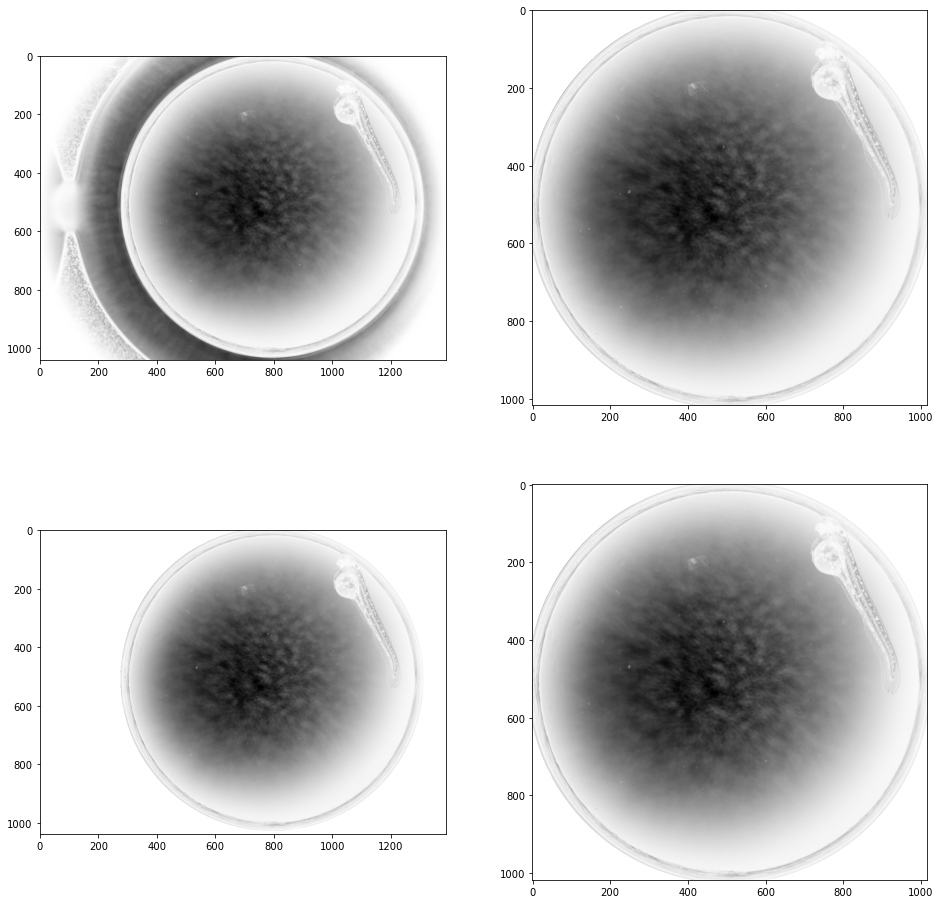

In [102]:
input_img = InputImage("zf21.czi")
input_img.processed = normalize_0_255(input_img.processed)
input_img.processed = np.uint8(input_img.processed)
input_img = find_well_props(input_img)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(input_img.og, 'binary')
ax[1].imshow(input_img.processed, 'binary')
ax[2].imshow(input_img.well_props.mask.masked, 'binary')
ax[3].imshow(input_img.well_props.mask.cropped_masked, 'binary')

# Finding largest object
_____________________________________________________________


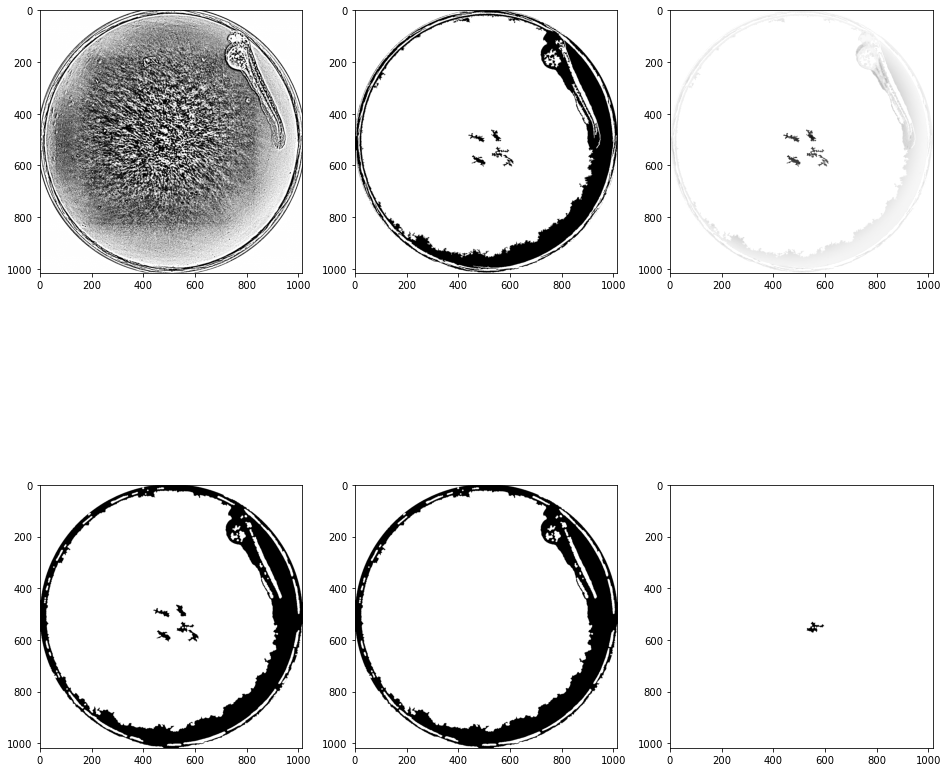

In [103]:
from skimage.morphology import binary_dilation, square
from skimage.exposure import rescale_intensity
from skimage.filters.ridges import frangi, meijering

masked = input_img.well_props.mask.cropped_masked

unsharp_ = unsharp_mask(equalize_adapthist(masked), amount=40, radius=3)
th = unsharp_ < 0.20

min_object_size = unsharp_.size * 0.0005
rso = remove_small_objects(th, min_size=min_object_size)

min_hole_size = unsharp_.size * 0.001
rsh = remove_small_holes(rso, area_threshold=min_hole_size)

th_ = rsh * input_img.well_props.mask.cropped

ope = binary_opening(th_, disk(3))
ope = binary_closing(th_, disk(3))

klo = keep_largest_object(ope)
klso = keep_second_largest_object(ope)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow((unsharp_), 'binary')
ax[1].imshow(th_, 'binary')
ax[2].imshow(th_ * masked, 'binary')
ax[3].imshow(ope, 'binary')
ax[4].imshow(klo, 'binary')
ax[5].imshow(klso, 'binary')

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________


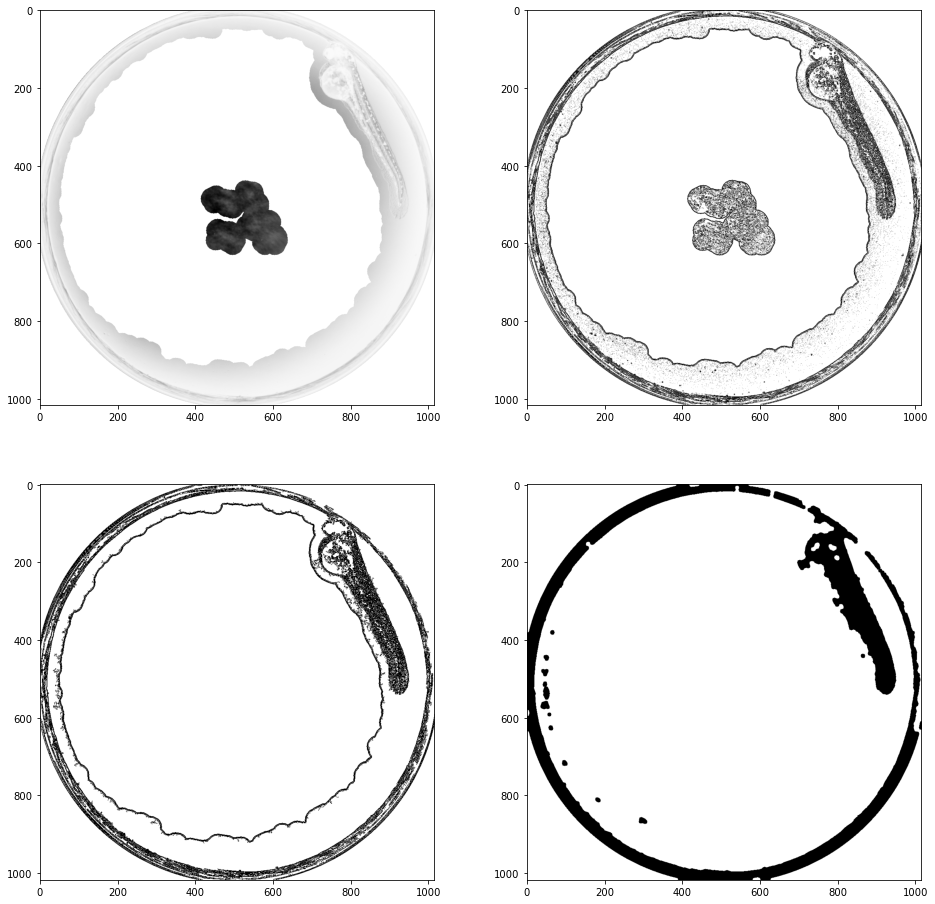

In [112]:
from src.filters import yen_th, sobel

dilmasik = binary_dilation(th_, disk(25)) * masked
unsharp_dilmasik = unsharp_mask(equalize_adapthist(dilmasik), amount=10, radius=1)
sob = sobel(unsharp_mask(equalize_adapthist(dilmasik), amount=30, radius=1))

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(dilmasik, 'binary')
ax[1].imshow(sob, 'binary')
ax[2].imshow(keep_largest_object(yen_th(sob)), 'binary')
ax[3].imshow(binary_opening(binary_closing(keep_largest_object(yen_th(sob)), disk(5)), disk(5)), 'binary')